# Causal diagrams and dealing with confounding

Here we will realise (i.e. simulate) the causal diagrams proposed by 
[Judea Pearl](https://en.wikipedia.org/wiki/Judea_Pearl) in his 
["The book of Why"](https://en.wikipedia.org/wiki/The_Book_of_Why). We will also analize the effect of confounding variables and of controlling for variables in various settings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from collections import defaultdict

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

import pygraphviz as gv
from PIL import Image
import io

## Functions

The functions below will help us generating variables linked together through causal diagrams. Basically, `generate_source` generates a variable assumed not to depend on others, while `generate_dependent` generates a variable that "listens to" (to use Pearl's term) other variables.

In [2]:
def generate_source(mean=0.0, dev=1.0, n_samples=10000):
    """
    Generate a sample of a Gaussian random variable
    with a certain `mean` (float), standard deviation
    `dev` (float) and size `n_samples` (int).
    """
    return np.random.normal(mean, dev, n_samples)

def generate_dependent(listens_to, transform=None, noise=0.4):
    """
    Generate a sample of a dependent variable 
    from input variables `listens_to` (list of 
    arrays) by applying `transform` (function) to
    them and adding Gaussian noise with standard 
    deviation `noise` (float).
    """
    
    # Default transformation:
    if transform is None:
        transform = sumvar
    
    # Generate dependent variable and noise:
    y = transform(*listens_to)
    e = generate_source(0, noise, len(y))
    
    return y + e

def sumvar(*list_of_variable_samples):
    """
    Return a sample (array of floats) composed 
    of the element-wise  sum of the samples of 
    variables in `list_of_variable_samples` 
    (list of arrays of floats).
    """
        
    return np.sum(list_of_variable_samples, axis=0)

The function below is used to draw pretty causal diagrams.

In [3]:
def plot_diagram(causal_links, rankdir='LR'):
    """
    Given a list of directed edges (represented
    by tuples of two elements), draws a graph.
    """
    G = gv.AGraph(directed=True, rankdir=rankdir)
    G.add_edges_from(causal_links)
    G.layout(prog='dot')
    G.draw('graph.svg')
    display(SVG('graph.svg'))

In [4]:
def plot_diagram(causal_links, rankdir='LR'):
    """
    Given a list of directed edges (represented
    by tuples of two elements), draws a graph.
    """
    G = gv.AGraph(directed=True, rankdir=rankdir)
    G.add_edges_from(causal_links)
    G.layout(prog='dot')
    img_bytes = G.draw(format='png')
    image = Image.open(io.BytesIO(img_bytes))
    display(image)

Finally, we will use a multivariate model to estimate the associations between variables. The association between _X_ and _Y_ is measured by the hability of _X_ to predict _Y_. For linear models, this means that the angular coefficient associated to _X_ are significantly different from zero. If the relationship between the variables is linear as well, we may verify if the model is able to predict the correct coefficient as well.

In this context, "_controlling_" for a variable means using it as another feature of the model (apart from the feature _X_ we want to check for causal connection to _Y_, that is always included in the model).

In [5]:
def compute_dependency(list_of_variables, y):
    """
    Compute the coefficients and their uncertainties 
    for the variables in `list_of_variables` (list of 
    arrays of floats) in a linear model for predicting
    `y`.
    
    Returns
    -------
    mean_coefs : array
        The coefficients for the variables in 
        `list_of_variables`, in the same order.
    dev_coeffts : array
        Uncertainties for the coefficients above.
    """
    # Prepare for modeling y as a function of input variables:
    X     = np.transpose(list_of_variables)
    model = LinearRegression()

    # LOOP over fit trials:
    coefs = []
    kf = KFold(n_splits=10)
    for train_idx, test_idx in kf.split(X):
        # Select subsample:
        train_X = X[train_idx]
        train_y = y[train_idx]
        # Fit the model:
        model.fit(train_X, train_y)
        # Store coefficients:
        coefs.append(model.coef_)

    # Compute coefficients and their errors:
    mean_coefs = np.mean(coefs,axis=0)
    dev_coefs  = np.std(coefs,axis=0)
    
    return mean_coefs, dev_coefs

def print_dependency(coefs, coefs_err):
    """
    Print the coefficients `coefs` (array)
    and their uncertainties `coefs_err` 
    (array) in the order they appear.
    """
    i = 0
    for m, e in zip(coefs, coefs_err):
        i += 1
        print('{}: {:6.3f} +/- {:6.3f}'.format(i, m, e))

def report_dependency(list_of_variables, y):
    """
    Compute and print the coefficients and 
    their uncertainties for the variables in 
    `list_of_variables` (list of arrays of floats) 
    in a linear model for predicting `y`.
    """
    print_dependency(*compute_dependency(list_of_variables, y))

The functions below are used to generate mock data that obeys the specified causal links:

In [6]:
def links2funcdict(causal_links):
    """
    Identify variables' dependencies in a list of causal links.
    
    Parameters
    ----------
    causal_links : list of tuples of str
        Each tuple (x, y) represents a causal relation x -> y.
        x and y (str) are names of variables. 

    Returns
    -------
    fdict : dict of set of str
        The keys are the names of dependent variables and the dict 
        values are the set of names of variables on which the 
        key depends on.
    """
    
    fdict = defaultdict(lambda: set())
    for link in causal_links:
        # Get sources `x` and dependent variables `y`:
        x = link[0]
        y = link[1]
        # Add `x` to `y` variables list:
        fdict[y].add(x)
        
    return dict(fdict)

In [7]:
def links2varset(causal_links, only_dep=False):
    """
    Get the set of variables present in the causal links.
    
    Parameters
    ----------
    causal_links : list of tuples of str
        Each tuple (x, y) represents a causal relation x -> y.
        x and y (str) are names of variables.
    only_dep : bool
        If True, only return dependent variables. If False,
        return all variables.

    Returns
    -------
    varset : set of str
        The set of names of variables (str) present in 
        `causal_links`. If `only_dep` is True, returns 
        only dependent variables; otherwise, return all.
    """
    
    varset = set()
    for x, y in causal_links:
        if only_dep is False:
            varset.add(x)
        varset.add(y)
    
    return varset

In [8]:
def links2sources(causal_links):
    """
    Find the set of independent variables (sources) in
    a list of causal links.
    
    Parameters
    ----------
    causal_links : list of tuples of str
        Each tuple (x, y) represents a causal relation x -> y.
        x and y (str) are names of variables.

    Returns
    -------
    src_set : set of str
        The set of names of independent variables (str) present in 
        `causal_links`.
    """
    all_set = links2varset(causal_links)
    dep_set = links2varset(causal_links, True)
    src_set = all_set - dep_set
    
    return src_set 

In [9]:
def ready_to_create(source_list, created_vars):
    """
    Inform whether all variables in `source_list` (set) already 
    have been created (i.e. are in set `created_vars`) or not.
    """
    #return source_list - created_vars
    return len(source_list - created_vars) == 0

In [10]:
def next_vars_to_create(fdict, created_vars):
    """
    Inform the dependent variables that already have the
    necessary variables to be created.

    Parameters
    ----------
    fdict : dict of sets of str
        The keys are the names of dependent variables and the dict 
        values are the set of names of variables on which the 
        key depends on.
    created_vars : set of str
        Set of names of already created variables.
    
    Returns
    -------
    new_vars : set of str
        Names of the variables that are ready to be created.
    """
    
    new_vars = set()
    for dep_var in fdict:
        if ready_to_create(fdict[dep_var], created_vars):
            new_vars.add(dep_var)
    
    return new_vars

In [11]:
def depvar_creation_order(fdict, sources):
    """
    List the order in which to create dependent variables so
    the required input variables are available for each 
    dependent variable.
    
    Parameters
    ----------
    fdict : dict of sets of str
        The keys are the names of dependent variables and the dict 
        values are the set of names of variables on which the 
        key depends on.
    sources : set of str
        Set of names of the independent variables (sources).
    
    Returns
    -------
    creation_order : list of str
        Order in which to create the dependent variables so to 
        guarantee that the necessary variables are already in place.
    """
    
    creation_order = []
    
    created_vars = sources.copy()
    depf = fdict.copy()
    while len(depf) > 0:
        # Get next variables to create:
        next_vars = next_vars_to_create(depf, created_vars)
        assert len(next_vars) > 0, 'Cannot create any variables given the existent ones.'
        # Add it to creation order and to created variables:
        creation_order += sorted(list(next_vars))
        created_vars.update(next_vars)
        # Remove created variables from dependency listing (no need to check again):
        for k in next_vars:
            depf.pop(k)
            
    return creation_order

In [12]:
def generate_causal_data(causal_links, n_samples=10000):
    """
    Generate random data that obeys the specified causal links.
    
    Parameters
    ----------
    causal_links : list of tuples of str
        Each tuple (x, y) represents a causal relation x -> y.
        x and y (str) are names of variables.
    n_samples : int
        Number of instances to generate.
    
    Returns
    -------
    df: DataFrame
        Mock data that obeys the specified causal links.
    """
    
    # Start DataFrame:
    df = pd.DataFrame()

    # Get set of sources:
    sources = links2sources(causal_links)
    
    # Generate source variables:
    for x in sorted(list(sources)):
        df[x] = generate_source(n_samples=n_samples)

    # Get variables' dependencies:
    dependencies = links2funcdict(causal_links)
    creation_order = depvar_creation_order(dependencies, sources)

    # Generate dependent variables:
    for y in creation_order:
        y_src = sorted(list(dependencies[y]))
        X = [df[s].values for s in y_src]
        df[y] = generate_dependent(X)
        
    return df

Functions for splitting data intro training and test sets:

In [13]:
def shuffled_pos(length, seed):
    """
    Return indices from 0 to `length` - 1 in a shuffled state, given random `seed`.
    """
    return np.random.RandomState(seed=seed).permutation(length)


def random_index_sets(size, set_fracs, seed):
    """
    Return sets of random indices (from 0 to `size` - 1) with lengths 
    given by ~ `size` * `set_fracs`.
    
    Input
    -----
    size : int
        The size of the index list to split into sets.
    set_fracs : iterable
        The fractions of the list of indices that each index set 
        should contain. 
    seed : int
        The seed for the random number generator.
        
    Returns
    -------
    indices : tuple of arrays
        The indices for each set.
    """
    
    assert np.isclose(np.sum(set_fracs), 1), '`set_fracs` should add up to one.'
    
    # Create randomized list of indices:
    shuffled_indices = shuffled_pos(size, seed)
    
    
    indices   = []
    set_start = [0]
    # Determine the sizes of the sets:
    set_sizes = [round(size * f) for f in set_fracs]
    set_sizes[0] = size - sum(set_sizes[1:])
    assert np.sum(set_sizes) == size, 'Set sizes should add up to total size.'
    
    for i in range(0, len(set_fracs) - 1):
        # Select indices for a set:
        set_start.append(set_start[i] + set_sizes[i])
        set_indices = shuffled_indices[set_start[i]:set_start[i + 1]]
        indices.append(set_indices)
        assert len(indices[i]) == len(set(indices[i])), 'There are repeating indices in a set.'
        
    # Select the indices for the last set:
    indices.append(shuffled_indices[set_start[-1]:])
    assert len(set(np.concatenate(indices))) == sum([len(i) for i in indices]), \
    'There are common indices between sets.'
    
    return tuple(indices)


def random_set_split(df, set_fracs, seed):
    """
    Split a DataFrame into randomly selected disjoint and complete sets.
    
    Input
    -----
    df : Pandas DataFrame
        The dataframe to split into a complete and disjoint set of sub-sets.
    set_fracs : array-like
        The fraction of `df` that should be put into each set. The length of 
        `set_fracs` determines the number of sub-sets to create
    seed : int
        The seed for the random number generator used to split `df`.
    
    Returns
    -------
    A tuple of DataFrames, one for each fraction in `set_fracs`, in that order.
    """
    # Get positional indices for each set:
    sets_idx = random_index_sets(len(df), set_fracs, seed)
    
    return tuple(df.iloc[idx] for idx in sets_idx)

In [14]:
def shuffle_data(data, random_state=None):
    """
    Shuffle the data while maintaining 
    the same index.
    
    Parameters
    ----------
    data : DataFrame or Series
        Data to be shuffled.
    random_state : int or None
        Seed for the number generator.
        Set to `None` for a random seed.
    
    Returns
    -------
    shuffled : DataFrame or Series
        Same as `data` but with shuffled
        entries, keeping the index order 
        exactly the same.
    """
    # Shuffle entries:
    shuffled = data.sample(len(data), random_state=random_state)
    # Keep the same index as before:
    shuffled.index = data.index
    
    return shuffled

## Simulating data from causal diagrams

### Junctions

The first step we want to take is to verify how controlling for the extra variable _Z_ affects the measured relationship between _X_ and _Y_ in the 3 basic junctions mentioned by Pearl: chains, forks and colliders.

#### Chain

In a chain, the variable _X_ affects _Y_ through another variable _Z_ referred to as "Mediator" (see the causal diagram below). A model using only _X_ as feature will inform us that it is associated to _Y_. However, if we "control" for _Z_ (i.e. include it in the model), this association is lost: all information used to predict _Y_ can be extracted from _Z_, rendering _X_ useless.

In Pearl's words, controlling the mediator closes this information path. This property is useful in practice since it justifies our use of "source" or "independent" variables: even if they are affected by other variables that do not interact with the other variables of interest, they can be used as though they were independent. In my words: the modelling should start at the observable variable in the chain closest to the target variable _Y_. 

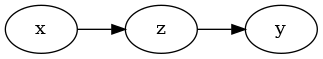

In [15]:
# Plot causal diagram:
plot_diagram([('x', 'z'), ('z', 'y')])

For simplicity, when simulating these causal diagrams, we will assume the relationship between a variable represented by a node in the diagram, $y$, and all inbound variables $x_i$ is linear plus some noise, i.e.: 

$$y = \sum_i \alpha_i x_i + \epsilon$$

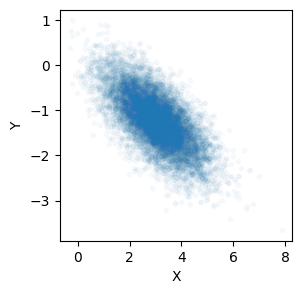

In [16]:
# Emulate causal diagram:
x = generate_source(3, 1.0)        # Independent variable (cause)
z = generate_dependent([-0.8 * x]) # Mediator
y = generate_dependent([0.5 * z])  # Dependent variable (effect)
# PS: the function `generate_dependent` introduces noise in the output.

# Relationship between X and Y:
pl.figure(figsize=(3,3))
pl.scatter(x, y, alpha=0.03, marker='.')
pl.xlabel('X')
pl.ylabel('Y')
pl.show()

Below we show that the coefficient measured for _X_ in a linear model is indeed the one that relate _Y_ to _X_. 

In [17]:
# Not controlling for Z:
report_dependency([x], y)

1: -0.406 +/-  0.001


Now if we control for _Z_, it fully explains _Y_ without any need for _X_. If we are interested in estimating the effect of _X_ on _Y_ but assume (erroneously) that _Z_ is a confounder and try to control for it, we will measure the wrong effect.

In [18]:
# Controlling for Z:
report_dependency([x, z], y)
# The output below shows the coefficients for the input variables [x, z] in the order they appear:

1: -0.020 +/-  0.003
2:  0.482 +/-  0.004


#### Fork

In the fork junction, one variable _Z_ affects two other variables _X_ and _Y_. This will create a correlation between _X_ and _Y_ that is called "spurious" since it does not reflect a causal relationship between them. In this configuration, _Z_ is called a "confounder".

In Pearl's words, controlling for the confounder closes the information flow along the path between _X_ and _Y_.

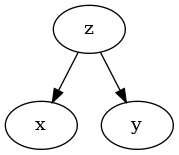

In [19]:
plot_diagram([('z', 'x'), ('z', 'y')], 'TD')

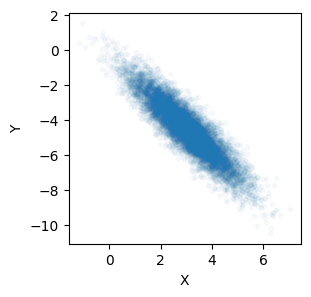

In [20]:
# Emulate causal diagram:
z = generate_source(3, 1.0) # Independent variable (confounder)
x = generate_dependent([z]) # Dependent variable (false treatment)
y = generate_dependent([-1.5 * z]) # Dependent variable (effect)

# Relationship between X and Y:
pl.figure(figsize=(3,3))
pl.scatter(x, y, alpha=0.03, marker='.')
pl.xlabel('X')
pl.ylabel('Y')
pl.show()

If we look for a relationship between _X_ and _Y_ , we will find one that is statistically significant, even though not causal:

In [21]:
# Not controlling for Z:
report_dependency([x], y)

1: -1.305 +/-  0.002


To properly measure the causal relationship between _X_ and _Y_ we must control for _Z_. In this case, we find no (causal) relation between both variables.

In [22]:
# Controlling for Z:
report_dependency([x, z], y)

1: -0.007 +/-  0.005
2: -1.497 +/-  0.005


#### Collider

In a collider junction, one variable _Z_ is affected by two other variables _X_ and _Y_. There is no causal relation
between _X_ and _Y_ and there is no spurious correlation as well since there is no interference between them and 
no other variable affects them both.

However, controlling for _Z_ will introduce a correlation between _X_ and _Y_ since the a certain value of _Z_ is the formed by the contribution from both variables given the constraint that _Z_ is fixed. In Pearl's words, controlling for a collider opens the information path.

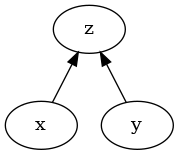

In [23]:
plot_diagram([('x', 'z'), ('y', 'z')], 'BT')

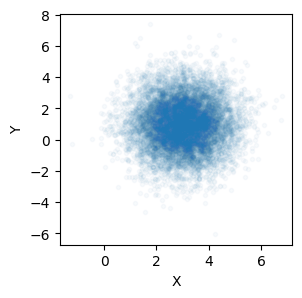

In [24]:
# Emulate causal diagram:
x = generate_source(3, 1.0) # Independent variable (cause)
y = generate_source(1, 1.5) # Independent variable (effect)
z = generate_dependent([x, 0.5 * y]) # Collider

# Relationship between X and Y:
pl.figure(figsize=(3,3))
pl.scatter(x, y, alpha=0.03, marker='.')
pl.xlabel('X')
pl.ylabel('Y')
pl.show()

As we see below, a model for _Y_ only based on _X_ will correctly inform us that the latter has no effect on the former. 

In [25]:
# Not controlling for Z:
report_dependency([x], y)

1:  0.010 +/-  0.006


However, if we control for _Z_, we would also find that _X_ is related to _Y_

In [26]:
# Controlling for Z:
report_dependency([x, z], y)

1: -1.548 +/-  0.004
2:  1.546 +/-  0.003


In [27]:
# Controlling for Z:
report_dependency([z], y)

1:  0.673 +/-  0.003


### Basic graphs

Now let's analyze important and simple graphs that are not basic junctions.

#### Proxy

When a variable _Z_ is unobservable, we might resort to an observable variable _P_ affected by _Z_. We call this variable a "proxy". 

Controlling the proxy has a similar effect to controlling the variable itself, albeit in a weaker sense: the information flow is not eliminated, only made smaller.

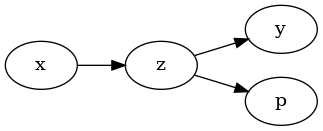

In [28]:
plot_diagram([('x', 'z'), ('z', 'y'), ('z', 'p')])

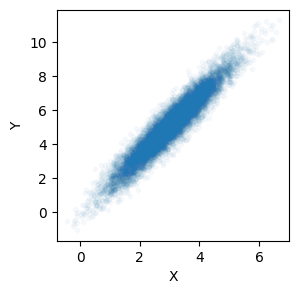

In [29]:
# Emulate causal diagram:
x = generate_source(3, 1.0) # Independent variable (cause)
z = generate_dependent([1.7 * x]) # Mediator
y = generate_dependent([z]) # Dependent variable (effect)
p = generate_dependent([z]) # Proxy

# Relationship between X and Y:
pl.figure(figsize=(3,3))
pl.scatter(x, y, alpha=0.03, marker='.')
pl.xlabel('X')
pl.ylabel('Y')
pl.show()

As in the chain case, the measured relationship between _X_ and _Y_  is the correct one.

In [30]:
# Not controlling for anything:
report_dependency([x], y)

1:  1.699 +/-  0.002


When controling for the proxy, part of the signal is lost due to the indirect constraint applied to _Z_ that will favour noises that reduce the value of _X_.

In [31]:
# Trying to control Z through the proxy P:
report_dependency([x, p], y)

1:  0.863 +/-  0.005
2:  0.492 +/-  0.003


#### Confounding

Let's analyze the situation in which there is a causal relation between _X_ and _Y_ but there is another unkown variable _Z_ (the confounder) that affects both _X_ and _Y_.

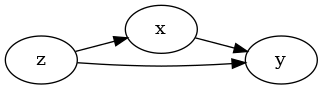

In [32]:
plot_diagram([('z', 'x'), ('z', 'y'), ('x', 'y')])

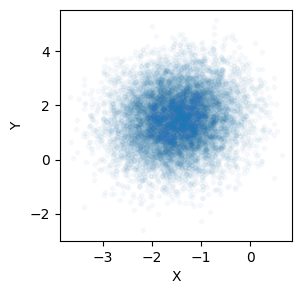

In [33]:
# Emulate causal diagram:
z = generate_source(3, 1.0)              # Independent variable (confounder)
x = generate_dependent([-0.5 * z])       # "Independent" variable (cause of interest)
y = generate_dependent([1.5 * z, 2 * x]) # Dependent variable (effect)

# Relationship between X and Y:
pl.figure(figsize=(3,3))
pl.scatter(x, y, alpha=0.03, marker='.')
pl.xlabel('X')
pl.ylabel('Y')
pl.show()

If we measure the relationship between _X_ and _Y_  we will get a wrong result:

In [34]:
# Not controlling for Z:
report_dependency([x], y)

1:  0.162 +/-  0.005


If we are able to identify the confounding variable and control for it, we will measure the correct 
result for the _X_ effect on _Y_.

In [35]:
# Controlling for Z:
report_dependency([x, z], y)

1:  1.987 +/-  0.005
2:  1.493 +/-  0.003


#### Noise (or an unobserved independent variable)

Another common issue is when we want to estimate the effect of _X_ on _Y_ but there are other variables on which _Y_ depend on that we are unaware of. In this case, _Z_ acts only as extra noise and does not bias our measurement of the causal effect of _X_ on _Y_.

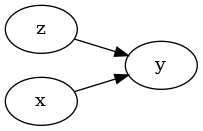

In [36]:
plot_diagram([('z', 'y'), ('x', 'y')])

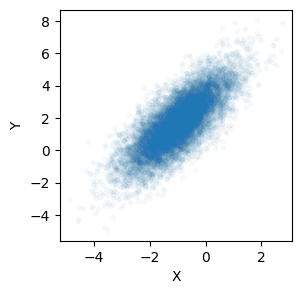

In [37]:
# Emulate causal diagram:
z = generate_source(3, 1.0) # Independent variable (confounder)
x = generate_source(-1, 1.0) # Dependent variable (false treatment)
y = generate_dependent([z, 1.3 * x]) # Dependent variable (effect)

# Relationship between X and Y:
pl.figure(figsize=(3,3))
pl.scatter(x, y, alpha=0.03, marker='.')
pl.xlabel('X')
pl.ylabel('Y')
pl.show()

In [38]:
# Not controlling for Z:
report_dependency([x], y)

1:  1.304 +/-  0.002


In [39]:
# Controlling for Z:
report_dependency([x, z], y)

1:  1.302 +/-  0.001
2:  1.001 +/-  0.001


As we see above, when we control for _Z_ we just reduce the error on the effect of _X_, but nothing changes with respect to the expected value.

#### Instrumental variable

An instrumental variable _I_ is a variable that causally affects only the independent variable _X_ and does not affect _Y_ nor is affected by _X_. In graph terms, _I_ point to and only to _X_.

One situation such variable is helpful is shown below, when _X_ causes _Y_ and vice-versa. By ignoring _X_ and controlling only for _I_ and _Y_, we open the chain path `i -> x -> y` and close the collider path `i -> x <- y`. So by modelling $y = f(i)$ we can assure if the path `x -> y` does exist or not.

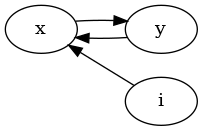

In [40]:
plot_diagram([('y', 'x'), ('i', 'x'), ('x', 'y')], 'RL')

Another situation where instrumental variables are useful is when there is a 
confounding variable _Z_ that is unobservable.

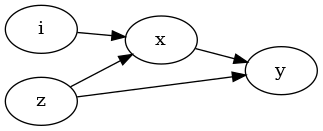

In [41]:
plot_diagram([('z', 'x'), ('z', 'y'), ('x', 'y'), ('i', 'x')])

Again, by ignoring _X_ and controlling for _I_  and _Y_ only, 
we open the chain path `i -> x -> y` and close the collider path `i -> x <- z`. 
In such case, the causal resulting causal diagram would be the following:

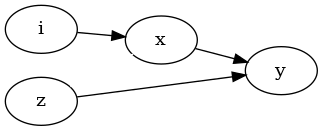

In [49]:
G = gv.AGraph(directed=True, rankdir='LR')
G.add_edges_from([('i', 'x'), ('x', 'y'), ('z', 'y')])
G.add_edge('z', 'x', color='white')
G.layout(prog='dot')
G.layout(prog='dot')
img_bytes = G.draw(format='png')
image = Image.open(io.BytesIO(img_bytes))
display(image)

The variable _Z_ becomes a simple source of noise for _Y_, and thus it does not affect the measurement of the relation through _X_, which only exists if the connection `x -> y` is there. Let's test this case with a simulation:

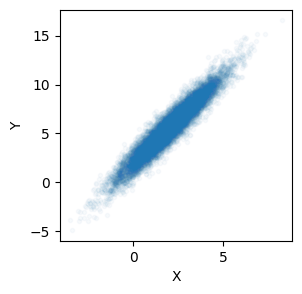

In [50]:
# Emulate causal diagram:
z = generate_source(3, 1.0) # Independent variable (confounder)
i = generate_source(-1, 1.0) # Dependent variable (false treatment)
x = generate_dependent([z, i])
y = generate_dependent([z, 1.3 * x]) # Dependent variable (effect)

# Relationship between X and Y:
pl.figure(figsize=(3,3))
pl.scatter(x, y, alpha=0.03, marker='.')
pl.xlabel('X')
pl.ylabel('Y')
pl.show()

In [51]:
# Using X and not I:
report_dependency([x], y)

1:  1.770 +/-  0.002


In [52]:
# Using the instrumental variable:
report_dependency([i], y)

1:  1.279 +/-  0.004


In [53]:
# Using the instrumental variable:
report_dependency([i], x)

1:  0.988 +/-  0.002


## Other cases

In [54]:
from xavy.causal_v0 import plot_diagram

### Receita de campanha e votos

In [55]:
edges = [('Raça', 'Votos 22'), ('Gênero', 'Votos 22'), ('UF', 'Votos 22'), ('Votos 18', 'Votos 22'),
         ('Raça', 'Votos 18'), ('Gênero', 'Votos 18'), ('UF', 'Votos 18'),    ('Verba', 'Votos 22'),
         ('Raça', 'Verba'),    ('Gênero', 'Verba'),    ('UF', 'Verba'),    ('Votos 18', 'Verba'),
         ('Raça', 'Cand. 18 e 22'), ('Gênero', 'Cand. 18 e 22'), ('UF', 'Cand. 18 e 22'), ('Votos 18', 'Cand. 18 e 22'),
         ('UF', 'Raça')]

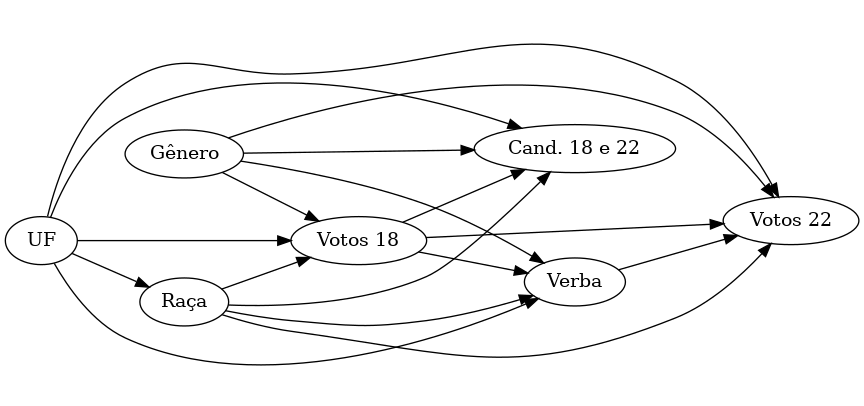

In [56]:
plot_diagram(edges)

In [57]:
receita_df = generate_causal_data(edges)

In [58]:
receita_df

,Gênero,UF,Raça,Votos 18,Cand. 18 e 22,Verba,Votos 22
0,-0.410610,-0.389547,-0.149483,-1.039779,-1.348879,-1.597041,-3.466600
1,-0.545050,0.750271,0.998192,1.697677,2.902465,2.664522,6.318861
2,1.100309,-0.447574,-0.180934,0.972578,0.493739,1.480320,3.399133
3,0.258577,-0.669977,-0.299177,-0.752580,-1.478135,-1.594742,-2.818015
4,-1.201510,-0.200996,0.249359,-1.153501,-2.330262,-2.020474,-4.267008
...,...,...,...,...,...,...,...
9995,-0.045813,0.967908,0.698503,1.602842,2.945580,3.124804,6.120336
9996,1.670032,0.423267,0.192059,2.159812,3.487601,4.811197,9.602996
9997,0.904579,0.737416,0.789832,1.905288,4.148080,3.828540,7.965458
9998,0.052423,0.456616,-0.075005,0.560828,1.319312,0.681547,1.411968


### Caminho da Escola

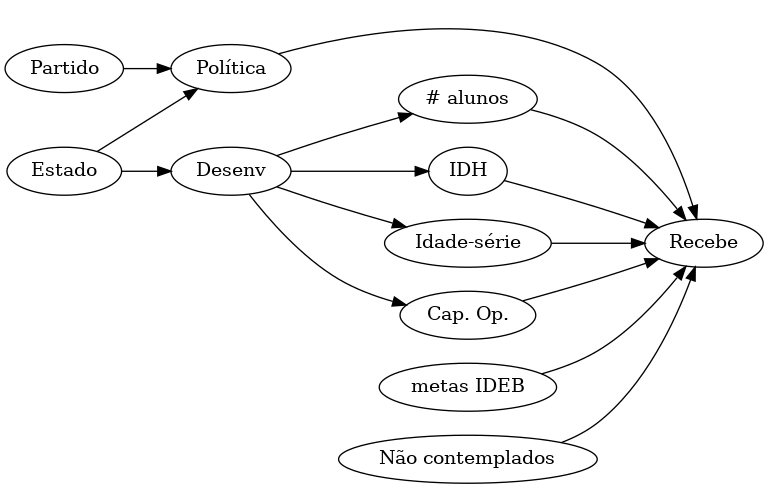

In [59]:
plot_diagram([('# alunos', 'Recebe'), ('IDH', 'Recebe'), ('metas IDEB', 'Recebe'), ('Não contemplados', 'Recebe'), ('Idade-série', 'Recebe'), ('Cap. Op.', 'Recebe'), ('Política', 'Recebe'), 
              ('Desenv', 'IDH'), ('Desenv', 'Idade-série'), ('Desenv', 'Cap. Op.'), ('Desenv', '# alunos'), ('Partido', 'Política'), ('Estado', 'Política'), ('Estado', 'Desenv')])

### Desmatamento

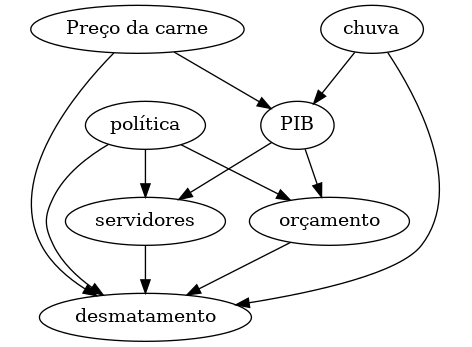

In [61]:
plot_diagram([('orçamento', 'desmatamento'), 
              ('servidores', 'desmatamento'), ('PIB', 'orçamento'), ('PIB', 'servidores'),
              ('Preço da carne', 'desmatamento'), 
              ('Preço da carne', 'PIB'), ('chuva', 'PIB'), 
              ('chuva', 'desmatamento'), ('política', 'orçamento'), 
              ('política', 'servidores'), ('política', 'desmatamento')], rankdir='TD')

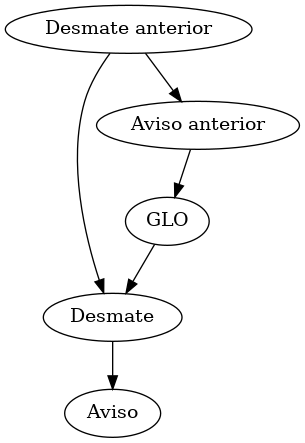

In [62]:
plot_diagram([('GLO', 'Desmate'), ('Desmate', 'Aviso'), ('Desmate anterior', 'Aviso anterior'), ('Aviso anterior', 'GLO'),
             ('Desmate anterior', 'Desmate')], rankdir='TD')

## Testing functions

In [63]:
import xavy.test as xtest

In [64]:
# Testes de funções:
g = [('orçamento', 'desmatamento'), 
              ('servidores', 'desmatamento'), ('PIB', 'orçamento'), ('PIB', 'servidores'),
              ('Preço da carne', 'desmatamento'), 
              ('Preço da carne', 'PIB'), ('chuva', 'PIB'), 
              ('chuva', 'desmatamento'), ('política', 'orçamento'), 
              ('política', 'servidores'), ('política', 'desmatamento')]
g_all = {'PIB', 'Preço da carne', 'chuva', 'desmatamento', 'orçamento', 'política', 'servidores'}
g_dep = {'PIB', 'desmatamento', 'orçamento', 'servidores'}
g_src = {'Preço da carne', 'chuva', 'política'}
g_fdict = {'desmatamento': {'Preço da carne','chuva','orçamento','política','servidores'}, 'orçamento': {'PIB', 'política'}, 'servidores': {'PIB', 'política'}, 'PIB': {'Preço da carne', 'chuva'}}
g_hdict = {'desmatamento': {'Preço da carne','chuva','orçamento','política','servidores'}, 'orçamento': {'PIB', 'política'}, 'servidores': {'PIB', 'política'}}

h = [('# alunos', 'Recebe'), ('IDH', 'Recebe'), ('metas IDEB', 'Recebe'), ('Não contemplados', 'Recebe'), ('Idade-série', 'Recebe'), ('Cap. Op.', 'Recebe'), ('Política', 'Recebe'), 
              ('Desenv', 'IDH'), ('Desenv', 'Idade-série'), ('Desenv', 'Cap. Op.'), ('Desenv', '# alunos'), ('Partido', 'Política'), ('Estado', 'Política'), ('Estado', 'Desenv')]
h_all = {'# alunos', 'Cap. Op.','Desenv','Estado','IDH','Idade-série','Não contemplados','Partido','Política','Recebe','metas IDEB'}
h_dep = {'# alunos', 'Cap. Op.', 'Desenv', 'IDH', 'Idade-série', 'Política', 'Recebe'}
h_src = {'Estado', 'Não contemplados', 'Partido', 'metas IDEB'}
h_fdict = {'Recebe': {'# alunos','Cap. Op.','IDH','Idade-série','Não contemplados','Política','metas IDEB'},'IDH': {'Desenv'},'Idade-série': {'Desenv'},'Cap. Op.': {'Desenv'},'# alunos': {'Desenv'},'Política': {'Estado', 'Partido'},'Desenv': {'Estado'}}

xtest.multi_test_function(links2varset, [(g,), (g, False), (g, True), (h,), (h, True)], [g_all, g_all, g_dep, h_all, h_dep])
xtest.multi_test_function(links2sources, [(g,), (h,)], [g_src, h_src])
xtest.multi_test_function(links2funcdict, [(g,), (h,)], [g_fdict, h_fdict])
xtest.multi_test_function(ready_to_create, [(g_fdict['orçamento'], g_src), (g_fdict['PIB'], g_src), (g_fdict['servidores'], g_src), (g_fdict['servidores'], {'política', 'PIB'})], [False, True, False, True])
xtest.multi_test_function(next_vars_to_create, [(g_fdict, g_src), (g_hdict, g_src | {'PIB'})], [{'PIB'}, {'servidores', 'orçamento'}])
xtest.multi_test_function(depvar_creation_order, [(g_fdict, g_src), (h_fdict, h_src)], [['PIB', 'orçamento', 'servidores', 'desmatamento'], ['Desenv', 'Política', '# alunos', 'Cap. Op.', 'IDH', 'Idade-série', 'Recebe']])

## Prototyping

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [66]:
from multiprocessing import Pool
from functools import partial

### Functions

**Aprimorar**

* O cálculo dos resíduos pode ser feito com predições de validação cruzada.
* Introduzir variações na geração de relações entre as variáveis.

In [67]:
def control_variable_pair(df, x, y, control=None, seed=None):

    # Security guard:
    assert type(x) in (str, int), '`x` should be either `str` or `int`, but it is {}'.format(type(x))
    assert type(y) in (str, int), '`y` should be either `str` or `int`, but it is {}'.format(type(y))
    
    # Split data for the two step in Double ML:
    primary_df, residual_df = random_set_split(df, [0.5, 0.5], seed)

    # If there is no control, residuals are the variables themselves:
    if control is None:
        res_df = pd.DataFrame({'x_residuals': df[x], 'y_residuals': df[y]})
        return res_df
        
    # Standardize input:
    if type(control) in (str, int):
        control = [control]
    
    # Instantiate a model:
    model = RandomForestRegressor()
    
    # Control the target and compute its residuals:
    model.fit(primary_df[control], primary_df[y])
    res_y = residual_df[y] - model.predict(residual_df[control])

    # Control the variable and compute its residuals:
    model.fit(primary_df[control], primary_df[x])
    res_x = residual_df[x] - model.predict(residual_df[control])

    res_df = pd.DataFrame({'x_residuals': res_x, 'y_residuals': res_y})

    return res_df

In [68]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [69]:
def avg_cross_val_score(df, x='x_residuals', y='y_residuals', scoring='neg_mean_squared_error'):
    
    #model = RandomForestRegressor()
    model = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=True)), ('fit', LinearRegression(fit_intercept=False))])
    scores = -cross_val_score(model, df[[x]], df[y], scoring=scoring)
    
    return scores.mean()

In [70]:
def avg_score_random(df, seed, x='x_residuals', y='y_residuals', scoring='neg_mean_squared_error'):
    assert scoring == 'neg_mean_squared_error', "The `scoring` 'neg_mean_squared_error' os the only one allowed, it is hard-coded."
    return np.mean([dfi[y].var() for dfi in random_set_split(df, [0.2] * 5, seed)])

In [71]:
def sample_random_score(df, offset, n_samples=4000, n_jobs=7):

    pool = Pool(n_jobs)
    seeds = list(range(offset, offset + n_samples))
    rnd_metric = pool.map(partial(avg_score_random, df), seeds)
    
    return np.array(rnd_metric)

In [72]:
def prediction_pvalue(res_df, seed=436, n_samples=4000):

    # Compute the error on `y` obtained from `x`:
    y_pred_var = avg_cross_val_score(res_df)

    # Compute variances of sampled sub-samples: 
    variance_sample = sample_random_score(res_df, seed, n_samples)
    
    # Fraction of random samples with variance lower than the one from prediction:
    pvalue = (variance_sample < y_pred_var).mean()
    
    return pvalue

In [73]:
def is_path_connected(df, x, y, control=None, alpha=0.02, seed=None):
    res_df = control_variable_pair(df, x, y, control, seed)
    pvalue = prediction_pvalue(res_df)
    return pvalue < alpha

### Testes

#### Casos Patológicos

Aparentemente, relações idênticas entre variáveis podem gerar patologias nos testes: no caso abaixo, `y` e `z` têm relação direta positiva.
O controle de `t` (_collider_) introduz uma correlação negativa. Parece que a última anula a primeira.

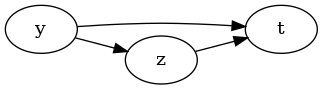

2: Function output "False" does not match expected `output` "True".


In [74]:
# Provável célula problemática:
j = [('y', 't'), ('y', 'z'), ('z', 't')]
plot_diagram(j)
df = generate_causal_data(j, n_samples=2000)
xtest.multi_test_function(is_path_connected, [(df, 'y', 'z', None), (df, 'y', 'z', 't')], [True, True])

In [75]:
# Reprodução da causa acima:
y = generate_source(n_samples=2000)
z = generate_dependent([y])
t = generate_dependent([y, z])
df = pd.DataFrame({'y': y, 'z': z, 't': t})
xtest.multi_test_function(is_path_connected, [(df, 'y', 'z', None), (df, 'y', 'z', 't')], [True, True])

2: Function output "False" does not match expected `output` "True".


In [76]:
# Eliminando patologia com relações não idênticas:
y = generate_source(n_samples=2000)
z = generate_dependent([0.7 * y])
t = generate_dependent([y, z])
df = pd.DataFrame({'y': y, 'z': z, 't': t})
xtest.multi_test_function(is_path_connected, [(df, 'y', 'z', None), (df, 'y', 'z', 't')], [True, True])

In [77]:
# Eliminando patologia com relações não idênticas:
y = generate_source(n_samples=2000)
z = generate_dependent([y])
t = generate_dependent([0.8 * y, z])
df = pd.DataFrame({'y': y, 'z': z, 't': t})
xtest.multi_test_function(is_path_connected, [(df, 'y', 'z', None), (df, 'y', 'z', 't')], [True, True])

In [78]:
# Eliminando patologia com relações não idênticas:
y = generate_source(n_samples=2000)
z = generate_dependent([y])
t = generate_dependent([y, 0.9 * z])
df = pd.DataFrame({'y': y, 'z': z, 't': t})
xtest.multi_test_function(is_path_connected, [(df, 'y', 'z', None), (df, 'y', 'z', 't')], [True, True])

2: Function output "False" does not match expected `output` "True".


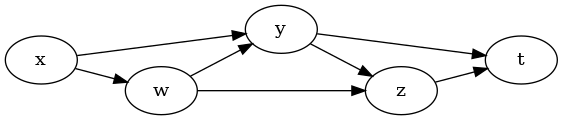

1: Function output "False" does not match expected `output` "True".


In [79]:
# Controlar T apaga relação entre X e Z: estranho.
j = [('x', 'w'), ('x', 'y'), ('w', 'y'), ('w', 'z'), ('y', 't'), ('y', 'z'), ('z', 't')]
plot_diagram(j)
df = generate_causal_data(j, n_samples=2000)
xtest.multi_test_function(is_path_connected, [(df, 'x', 'z', ['t'])], [True])

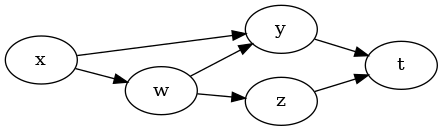

In [80]:
# Remoção de uma conexão elimina a patologia:
j = [('x', 'w'), ('x', 'y'), ('w', 'y'), ('w', 'z'), ('y', 't'), ('z', 't')]
plot_diagram(j)
df = generate_causal_data(j, n_samples=2000)
xtest.multi_test_function(is_path_connected, [(df, 'x', 'z', ['t'])], [True])

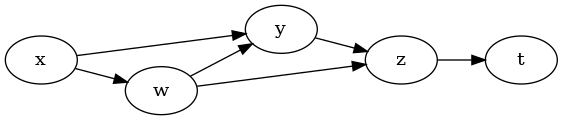

In [81]:
# Remoção de uma conexão elimina a patologia:
j = [('x', 'w'), ('x', 'y'), ('w', 'y'), ('w', 'z'), ('y', 'z'), ('z', 't')]
plot_diagram(j)
df = generate_causal_data(j, n_samples=2000)
xtest.multi_test_function(is_path_connected, [(df, 'x', 'z', ['t'])], [True])

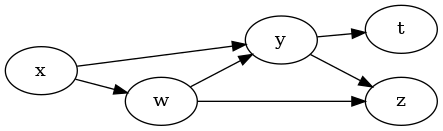

In [82]:
# Remoção de uma conexão elimina a patologia:
j = [('x', 'w'), ('x', 'y'), ('w', 'y'), ('w', 'z'), ('y', 't'), ('y', 'z')]
plot_diagram(j)
df = generate_causal_data(j, n_samples=2000)
xtest.multi_test_function(is_path_connected, [(df, 'x', 'z', ['t'])], [True])

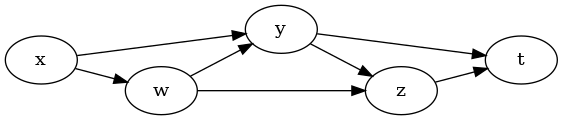

In [83]:
# Relações que ocorrem conforme o esperado:

j = [('x', 'w'), ('x', 'y'), ('w', 'y'), ('w', 'z'), ('y', 't'), ('y', 'z'), ('z', 't')]
plot_diagram(j)
df = generate_causal_data(j, n_samples=2000)

xtest.multi_test_function(is_path_connected, 
                          [(df, 'x', 't', ['z']), 
                           (df, 'x', 'z', ['w']), 
                           (df, 'w', 't', ['x'])], 
                          [True, True, True])

xtest.multi_test_function(is_path_connected, 
                          [(df, 'x', 't', None), (df, 'x', 'z', None), (df, 'w', 't', None)], 
                          [True, True, True])

xtest.multi_test_function(is_path_connected, 
                          [(df, 'x', 't', ['z', 'y']), (df, 'x', 'z', ['y', 'w']), (df, 'w', 't', ['y', 'z'])], 
                          [False, False, False])

#### Casos normais

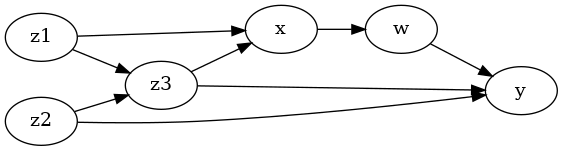

In [84]:
j = [('z1', 'x'), ('z1', 'z3'), ('z3', 'x'), ('z3', 'y'), ('x', 'w'), ('w', 'y'), ('z2', 'z3'), ('z2', 'y')]
plot_diagram(j)
df = generate_causal_data(j, n_samples=2000)

xtest.multi_test_function(is_path_connected, 
                          [(df, 'z1', 'y', None), (df, 'z2', 'w', None), (df, 'z2', 'z1', None)], 
                          [True, True, False])
xtest.multi_test_function(is_path_connected, 
                          [(df, 'z1', 'y', ['z3', 'z2', 'w']), (df, 'z2', 'w', ['x']), (df, 'z2', 'z1', ['x'])], 
                          [False, False, True])
xtest.multi_test_function(is_path_connected, 
                          [(df, 'z1', 'y', ['z3', 'w']), (df, 'z2', 'w', ['x', 'y']), (df, 'z2', 'z1', ['w'])], 
                          [True, True, True])

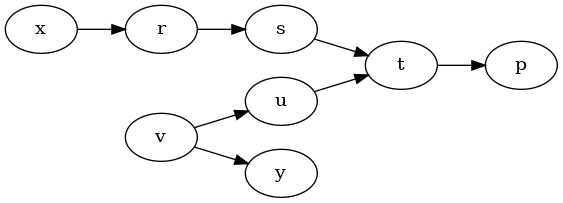

In [85]:
j = [('x', 'r'), ('r', 's'), ('s', 't'), ('t', 'p'), ('u', 't'), ('v', 'u'), ('v', 'y')]
plot_diagram(j)
df = generate_causal_data(j, n_samples=2000)

xtest.multi_test_function(is_path_connected, 
                          [(df, 's', 'u', None), (df, 'x', 'p', None), (df, 'y', 'p', None)], 
                          [False, True, True])
xtest.multi_test_function(is_path_connected, 
                          [(df, 'x', 's', 'r'), (df, 'x', 'y', 't'), (df, 'x', 'y', ['t', 'v']), (df, 'u', 'y', ['v'])], 
                          [False, True, False, False])

### Restos

In [86]:
#pd.plotting.scatter_matrix(df, alpha=0.1, figsize=(8,8))
#pl.show()

In [87]:
res_df = control_variable_pair(df, 'p', 's', ['x'])

In [88]:
from sklearn.linear_model import LinearRegression

In [89]:
model = LinearRegression()
cross_val_score(model, res_df[['x_residuals']], res_df['y_residuals'], scoring='neg_mean_squared_error').mean()

-0.39138989906807486

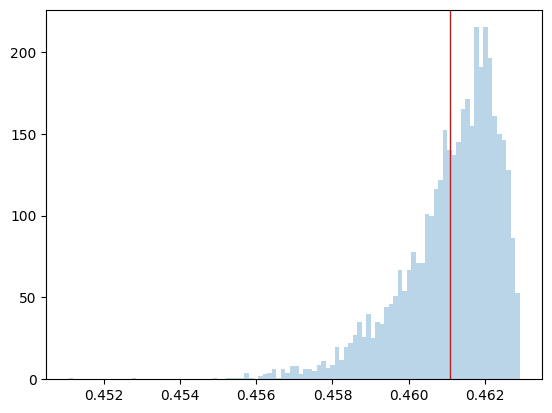

In [90]:
rnd_var = sample_random_score(res_df, 2124)
pl.hist(rnd_var, bins=100, alpha=0.3)
pl.axvline(res_df['y_residuals'].var(), color='firebrick', linewidth=1)
pl.show()

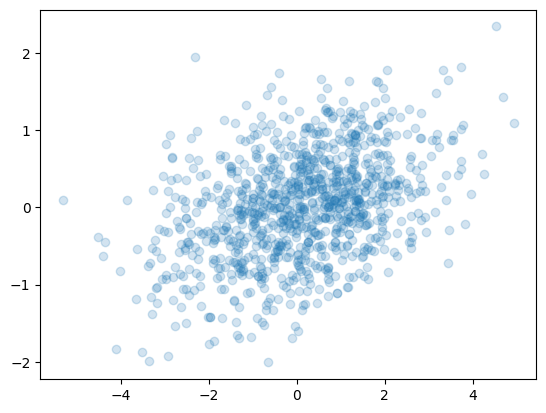

In [91]:
pl.scatter(res_df['x_residuals'], res_df['y_residuals'], alpha=0.2)
pl.show()

In [92]:
print('COLLIDER - FREE')
report_dependency([df['z']], df['x'])
print('COLLIDER - CONTROLLING')
report_dependency([df['z'], df['y']], df['x'])

COLLIDER - FREE


KeyError: 'z'

In [ ]:
print('CHAIN - FREE')
report_dependency([df['w']], df['y'])
print('CHAIN - CONTROLLING')
report_dependency([df['w'], df['z']], df['y'])

In [93]:
print('FORK - FREE')
report_dependency([df['y']], df['k'])
print('FORK - CONTROLLING')
report_dependency([df['y'], df['x']], df['k'])

FORK - FREE


KeyError: 'k'

In [94]:
df.head()

,v,x,r,u,y,s,t,p
0,0.175838,0.694433,0.673906,-0.106007,-0.633689,1.383663,1.212474,0.528137
1,0.094427,-0.304608,-0.374389,0.300577,0.035089,-0.076412,-0.789510,-1.092316
2,-1.096500,1.039192,0.301465,-1.356037,-1.168442,0.740515,-1.191413,-1.566093
3,-1.379458,-0.384630,0.076562,-1.563435,-1.372034,0.359053,-1.020242,-1.046680
4,-0.996447,0.610971,0.976962,-1.401417,-0.579218,0.915527,-0.454761,-0.846744


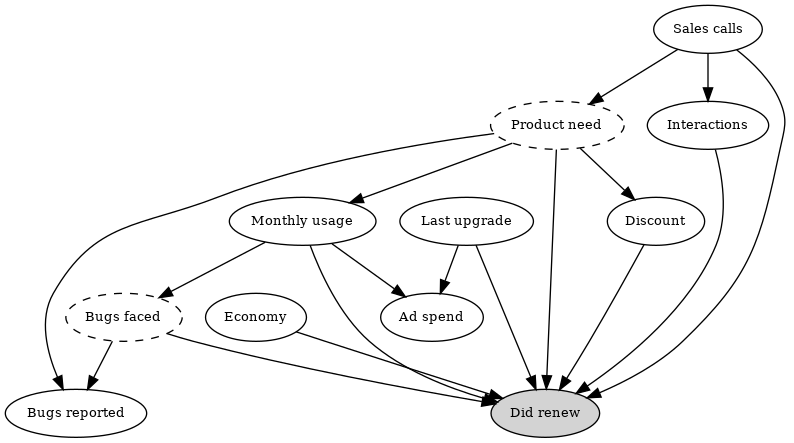

In [95]:
import pygraphviz as graphviz
names = [
         "Bugs reported", "Monthly usage", "Sales calls", "Economy",
         "Discount", "Last upgrade", "Ad spend", "Interactions"
]
g = graphviz.AGraph(directed=True)
for name in names:
    g.add_node(name, fontsize="10")
g.add_node("Product need", style="dashed", fontsize="10")
g.add_node("Bugs faced", style="dashed", fontsize="10")
g.add_node("Did renew", style="filled", fontsize="10")

g.add_edge("Product need", "Did renew")
g.add_edge("Product need", "Discount")
g.add_edge("Product need", "Bugs reported")
g.add_edge("Product need", "Monthly usage")
g.add_edge("Discount", "Did renew")
g.add_edge("Monthly usage", "Bugs faced")
g.add_edge("Monthly usage", "Did renew")
g.add_edge("Monthly usage", "Ad spend")
g.add_edge("Economy", "Did renew")
g.add_edge("Sales calls", "Did renew")
g.add_edge("Sales calls", "Product need")
g.add_edge("Sales calls", "Interactions")
g.add_edge("Interactions", "Did renew")
g.add_edge("Bugs faced", "Did renew")
g.add_edge("Bugs faced", "Bugs reported")
g.add_edge("Last upgrade", "Did renew")
g.add_edge("Last upgrade", "Ad spend")
g.layout(prog='dot')
img_bytes = g.draw(format='png')
image = Image.open(io.BytesIO(img_bytes))
display(image)

# Lixo

In [ ]:
def avg_score_random(df, seed, x='x_residuals', y='y_residuals', scoring='neg_mean_squared_error'):
    shuffled_df = pd.DataFrame({x: df[x], y: shuffle_data(df[y], seed)})
    return avg_cross_val_score(shuffled_df, x, y, scoring)

In [326]:
def frac_Votos(ap, ar, vp, vr, roverp):
    return ap * vp / (ap + ar * roverp) + ar * vr / (ar + ap / roverp)

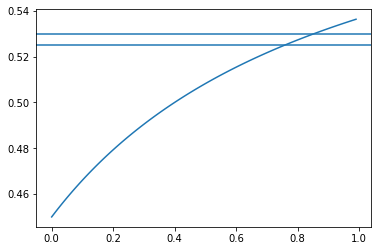

In [331]:
x = np.arange(0, 1, 0.01)
y = frac_Votos(x, 0.85, 0.62, 0.45, 1.13)
pl.axhline(frac_Votos(0.76, 0.85, 0.62, 0.45, 1.13))
pl.axhline(frac_Votos(1.0, 1.0, 0.62, 0.45, 1.13))
pl.plot(x, y)
pl.show()